# Take-home exam 3

In [2]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scienceplots

# Plot style
plt.style.use(['science', 'nature', 'high-vis'])

## Problem 1

In [4]:
def circle_map(x, r):
    return (x + r - (1/(2 * np.pi)) * np.sin(2 * np.pi * x)) % 1.0

In [45]:
def derivative_circle_map(x, r):
    return (1 - np.cos(2 * np.pi * x)) % 1.0

In [46]:
# Lyapunov exponent
def lyapunov(r_min = 1.0, 
             r_max = 4.0, 
             partitions = 1000,
             transient = 1000, 
             nontransient = 9000, 
             initial_x = 0.20,
             map: callable = circle_map,
             derivative_map: callable = derivative_circle_map):
    
    # Values for r
    r_values = np.linspace(r_min, r_max, partitions)

    # Initialize Lyapunov exponent
    log_list = np.zeros(nontransient)
    lyapunov_r = np.zeros(partitions)
    
    print("---------------------------------------------------")
    print("Calculating the Lyapunov exp...")
    print("---------------------------------------------------")

    # For each parameter value
    for i, r in enumerate(r_values):
        
        # Initial condition
        x = initial_x
        
        # Run transient iterations
        for _ in range(transient):
            x = map(x, r)
            
        # print(f"Transient iterations done!")
        
        # Record iterations after transient
        for _ in range(nontransient):

            # Get the next value
            x = map(x, r)

            # Compute the derivative
            deriv = derivative_map(x, r)

            # Log of it
            log = np.log(abs(deriv) + 1e-10)

            # Append to the list
            log_list[_] = log

        # Compute the Lyapunov exponent
        lyapunov_r[i] = np.mean(log_list)

    print("Done!")
    print("---------------------------------------------------")

    return lyapunov_r, r_values

In [47]:
# Call it
lyapunov_val, omega = lyapunov(r_min = 0.0,
                           r_max = 2.0, 
                           partitions = 1000,
                           transient = 2000, 
                           nontransient = 1000, 
                           initial_x = 0.50,
                           map = circle_map,
                           derivative_map = derivative_circle_map)

---------------------------------------------------
Calculating the Lyapunov exp...
---------------------------------------------------
Done!
---------------------------------------------------


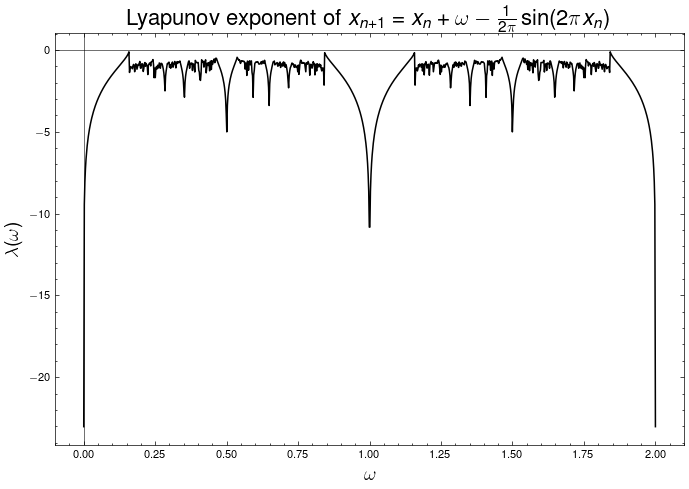

In [50]:
# Plot the results
plt.figure(figsize=(7, 5))
plt.plot(omega, lyapunov_val, lw = 1.1, c = "k")
plt.title('Lyapunov exponent of ' + r"$x_{n+1} = x_n + \omega - \frac{1}{2\pi}\sin(2\pi x_n)$", fontsize=16)
plt.ylabel(r"$\lambda(\omega)$", fontsize=14)
plt.xlabel(r"$\omega$", fontsize=14)
plt.axhline(0, color='black', lw=0.4)
plt.axvline(0, color='black', lw=0.4)
# Make ticks smaller
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.1, 1.1)
plt.savefig('./plots/cir_lya.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 2

In [139]:
@jit(nopython=True)
def map_2d(state, b=0.5, a=1.7):
    x, y = state
    x_new = 1 - a * np.abs(x) + y
    y_new = b * x
    return x_new, y_new

def two_map(x, b=0.5):
    global y_state
    if not hasattr(two_map, 'y_state'):
        two_map.y_state = 0.0
    
    # Apply the 2D map
    x_new, y_new = map_2d((x, two_map.y_state), b, a=1.7)
    
    # Update
    two_map.y_state = y_new
    
    return x_new

In [151]:
# Initial condition
x_0 = 0.1
y_0 = 0.1

# Parameters
b = 0.50
a = 1.70

# Number of iterations
n_iterations = 1500

# Initialize arrays
x_values = np.zeros(n_iterations)
y_values = np.zeros(n_iterations)

# Set initial values
x_values[0] = x_0
y_values[0] = y_0

# Iterate
for i in range(1, n_iterations):
    x_values[i] = two_map(x_values[i-1], b)
    y_values[i] = two_map.y_state

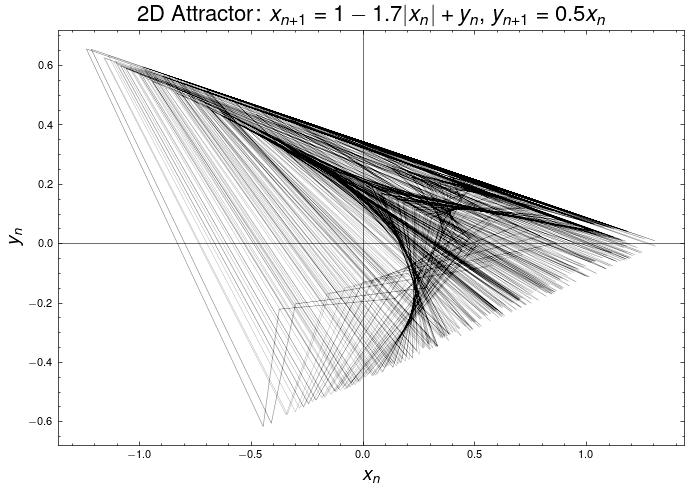

In [158]:
# Plot the results
plt.figure(figsize=(7, 5))
plt.plot(x_values[700:], y_values[700:], lw=0.1, c='k')
plt.title('2D Attractor: $x_{n+1} = 1 - 1.7|x_n| + y_n$, $y_{n+1} = 0.5 x_n$', fontsize=16)
plt.xlabel(r"$x_n$", fontsize=14)
plt.ylabel(r"$y_n$", fontsize=14)
plt.axhline(0, color='black', lw=0.4)
plt.axvline(0, color='black', lw=0.4)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.savefig('./plots/two_dim_map.png', dpi=300, bbox_inches='tight')    
plt.show()

In [61]:
# Fractal dimension
# Fractal dimension and Lyapunov exponents for 2D map

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

@jit(nopython=True)
def henon_map_2d(x, y, a, b):
    """
    Two-dimensional Henon-like map
    x_{n+1} = 1 - a|x_n| + y_n
    y_{n+1} = bx_n
    """
    x_new = 1 - a * np.abs(x) + y
    y_new = b * x
    return x_new, y_new

@jit(nopython=True)
def jacobian_henon(x, y, a, b):
    """
    Jacobian matrix of the Henon-like map
    J = [[∂f/∂x, ∂f/∂y],
         [∂g/∂x, ∂g/∂y]]
    
    where f(x,y) = 1 - a|x| + y
          g(x,y) = bx
    """
    # Derivatives
    if x >= 0:
        df_dx = -a  # derivative of -a|x| when x > 0
    else:
        df_dx = a   # derivative of -a|x| when x < 0
    
    df_dy = 1.0
    dg_dx = b
    dg_dy = 0.0
    
    return np.array([[df_dx, df_dy],
                     [dg_dx, dg_dy]])

@jit(nopython=True)
def lyapunov_2d_single(a, b, n_iterations=10000, transient=2000):
    """
    Calculate the largest Lyapunov exponent for given parameters a, b
    """
    # Initial conditions
    x, y = 0.01, 0.01
    
    # Initial tangent vector (normalized)
    u = np.array([1.0, 0.0])
    v = np.array([0.0, 1.0])
    
    # Skip transient
    for _ in range(transient):
        x, y = henon_map_2d(x, y, a, b)
    
    lyap_sum_1 = 0.0
    lyap_sum_2 = 0.0
    
    for _ in range(n_iterations):
        # Get Jacobian at current point
        J = jacobian_henon(x, y, a, b)
        
        # Evolve tangent vectors
        u_new = J @ u
        v_new = J @ v
        
        # Gram-Schmidt orthonormalization
        # First vector
        norm_u = np.sqrt(u_new[0]**2 + u_new[1]**2)
        if norm_u > 0:
            u = u_new / norm_u
            lyap_sum_1 += np.log(norm_u)
        
        # Second vector (orthogonalize against first)
        proj = np.dot(v_new, u) * u
        v_orth = v_new - proj
        norm_v = np.sqrt(v_orth[0]**2 + v_orth[1]**2)
        if norm_v > 0:
            v = v_orth / norm_v
            lyap_sum_2 += np.log(norm_v)
        
        # Evolve the system
        x, y = henon_map_2d(x, y, a, b)
    
    lambda1 = lyap_sum_1 / n_iterations
    lambda2 = lyap_sum_2 / n_iterations
    
    return lambda1, lambda2

def lyapunov_2d_heatmap(a_min=1.0, a_max=2.0, b_min=-0.8, b_max=0.8, 
                        resolution=100, n_iterations=5000):
    """
    Generate a heatmap of Lyapunov exponents over parameter space
    """
    a_values = np.linspace(a_min, a_max, resolution)
    b_values = np.linspace(b_min, b_max, resolution)
    
    lambda1_map = np.zeros((resolution, resolution))
    lambda2_map = np.zeros((resolution, resolution))
    
    print("Calculating Lyapunov exponents...")
    print("This may take a while...")
    
    for i, a in enumerate(a_values):
        if i % 10 == 0:
            print(f"Progress: {i}/{resolution} ({100*i/resolution:.1f}%)")
        
        for j, b in enumerate(b_values):
            try:
                lambda1, lambda2 = lyapunov_2d_single(a, b, n_iterations)
                lambda1_map[j, i] = lambda1  # Note: j,i for proper orientation
                lambda2_map[j, i] = lambda2
            except:
                lambda1_map[j, i] = np.nan
                lambda2_map[j, i] = np.nan
    
    print("Done!")
    return lambda1_map, lambda2_map, a_values, b_values

# Calculate the Lyapunov exponent maps
lambda1_map, lambda2_map, a_values, b_values = lyapunov_2d_heatmap(
    a_min=-4.0, a_max=4.0, 
    b_min=-4.0, b_max=4.0, 
    resolution=350,
    n_iterations=1000
)

Calculating Lyapunov exponents...
This may take a while...
Progress: 0/350 (0.0%)
Progress: 10/350 (2.9%)
Progress: 20/350 (5.7%)
Progress: 30/350 (8.6%)
Progress: 40/350 (11.4%)
Progress: 50/350 (14.3%)
Progress: 60/350 (17.1%)
Progress: 70/350 (20.0%)
Progress: 80/350 (22.9%)
Progress: 90/350 (25.7%)
Progress: 100/350 (28.6%)
Progress: 110/350 (31.4%)
Progress: 120/350 (34.3%)
Progress: 130/350 (37.1%)
Progress: 140/350 (40.0%)
Progress: 150/350 (42.9%)
Progress: 160/350 (45.7%)
Progress: 170/350 (48.6%)
Progress: 180/350 (51.4%)
Progress: 190/350 (54.3%)
Progress: 200/350 (57.1%)
Progress: 210/350 (60.0%)
Progress: 220/350 (62.9%)
Progress: 230/350 (65.7%)
Progress: 240/350 (68.6%)
Progress: 250/350 (71.4%)
Progress: 260/350 (74.3%)
Progress: 270/350 (77.1%)
Progress: 280/350 (80.0%)
Progress: 290/350 (82.9%)
Progress: 300/350 (85.7%)
Progress: 310/350 (88.6%)
Progress: 320/350 (91.4%)
Progress: 330/350 (94.3%)
Progress: 340/350 (97.1%)
Done!


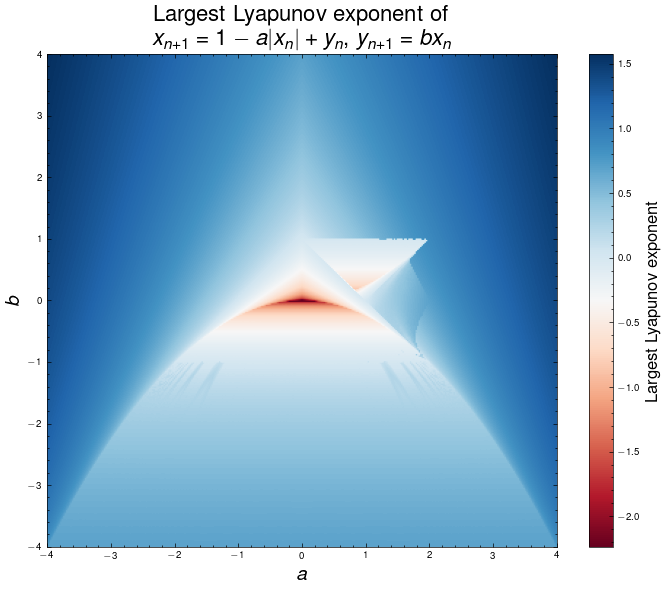

In [ ]:
# Plot the largest Lyapunov exponent
plt.figure(figsize=(7, 6))

# Create the heatmap
im = plt.imshow(lambda1_map, 
                extent=[a_values[0], a_values[-1], b_values[0], b_values[-1]],
                aspect='auto', 
                origin='lower',
                cmap='RdBu'
                #vmin=-1, vmax=1
)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label(r'Largest Lyapunov exponent', fontsize=12)

# Add contour lines for λ = 0
# plt.contour(a_values, b_values, lambda1_map, levels=[0], colors='black', linewidths=1.0, ls ='-')

# Labels and title
plt.xlabel(r'$a$', fontsize = 14)
plt.ylabel(r'$b$', fontsize = 14)
plt.title("Largest Lyapunov exponent of\n" +
          r'$x_{n+1} = 1 - a|x_n| + y_n$, $y_{n+1} = bx_n$', fontsize=16)

# # Mark the specific point from part (a)
#plt.plot(1.7, 0.5, 'wo', markersize=8, markeredgecolor='black', markeredgewidth=2)
#plt.text(1.72, 0.52, '(1.7, 0.5)', fontsize=10, color='white', weight='bold')
plt.tight_layout()
#plt.savefig('./plots/lyapunov_2d.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 3

In [3]:
# Map
def escape_map(x, a=2):
    x_new = (a / 2)*(1 - abs(1 - 2*x))
    return x_new

In [4]:
# Set a
a = 2.0 + 0.01

# Number of iterations
n_iterations = 790

# Initialize array
x_values = np.zeros(n_iterations)

# Set initial condition
x_values[0] = 0.1

# Iterate
for i in range(1, n_iterations):
    x_values[i] = escape_map(x_values[i-1], a)

    if x_values[i] < 0 or x_values[i] > 1:
        print(f"Escaped at iteration {i}: x = {x_values[i]}")

Escaped at iteration 781: x = 1.0031145621157798
Escaped at iteration 782: x = -0.006260269852717321
Escaped at iteration 783: x = -0.012583142403961824
Escaped at iteration 784: x = -0.025292116231963327
Escaped at iteration 785: x = -0.05083715362624636
Escaped at iteration 786: x = -0.10218267878875528
Escaped at iteration 787: x = -0.20538718436539816
Escaped at iteration 788: x = -0.4128282405744503
Escaped at iteration 789: x = -0.829784763554645


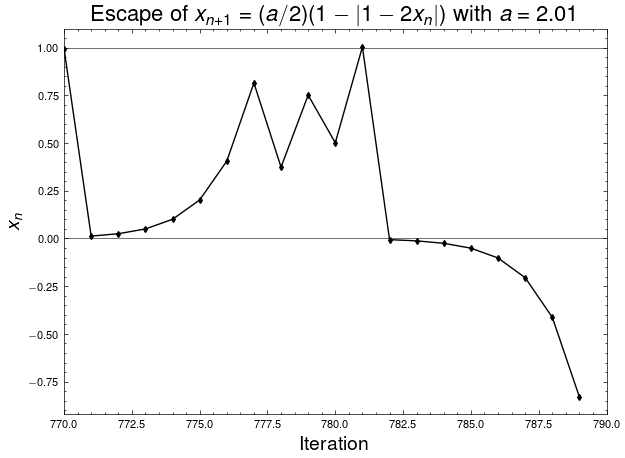

In [133]:
plt.figure(figsize=(7, 5))

plt.title("Escape of " + r'$x_{n+1} = (a/2)(1 - |1 - 2x_n|)$ with $a = 2.01$', fontsize=16)

plt.plot(range(n_iterations), x_values, markersize=3, c='k', alpha=1.0, lw=1.0, marker ='d')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel(r'$x_n$', fontsize=14)

plt.axhline(0, color='black', lw=0.4)
plt.axhline(1, color='black', lw=0.4)
# plt.axvline(0, color='black', lw=0.4)
# Make ticks smaller and only show integer ticks
plt.tick_params(axis='both', which='major', labelsize=8)

plt.xlim(770,790)
# plt.savefig('./plots/escape_map.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Problem 3(b): Fractal dimension using escape rate method (Simplified)

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

@jit(nopython=True)
def escape_map_jit(x, a):
    """Escape map"""
    return (a / 2) * (1 - np.abs(1 - 2*x))

@jit(nopython=True)
def escape_time(x0, a, max_iter=5000):
    """Calculate escape time for initial condition x0"""
    x = x0
    for n in range(max_iter):
        x = escape_map_jit(x, a)
        if x < 0 or x > 1:
            return n
    return max_iter

@jit(nopython=True)
def calculate_fractal_dimension(epsilon_val, resolution=5000):
    """Calculate fractal dimension using escape rate method"""
    a = 2.0 + epsilon_val
    
    # Grid of initial conditions
    x_grid = np.linspace(0.001, 0.999, resolution)
    
    # Count surviving points
    surviving_points = 0
    for x0 in x_grid:
        if escape_time(x0, a) == 5000:  # Didn't escape
            surviving_points += 1
    
    # Calculate survival probability and escape rate
    survival_prob = surviving_points / resolution
    
    if survival_prob > 0:
        escape_rate = -np.log(survival_prob)
        # Fractal dimension from escape rate
        dimension = max(0.0, 1.0 - escape_rate / np.log(2.0 + epsilon_val))
    else:
        dimension = 0.0
        escape_rate = np.inf
    
    return dimension, escape_rate, survival_prob

# Calculate fractal dimension vs epsilon
#epsilon_values = np.logspace(-5, -3.8, 30)
epsilon_values = np.linspace(0.00, 0.0001, 30)  # Adjusted for better resolution
dimensions = []
escape_rates = []

print("Calculating fractal dimensions...")
for i, eps in enumerate(epsilon_values):
    if i % 5 == 0:
        print(f"Progress: {i+1}/{len(epsilon_values)}")
    
    dim, gamma, _ = calculate_fractal_dimension(eps, resolution=3000)
    dimensions.append(dim)
    escape_rates.append(gamma)

dimensions = np.array(dimensions)
escape_rates = np.array(escape_rates)

Calculating fractal dimensions...
Progress: 1/30
Progress: 6/30
Progress: 11/30
Progress: 16/30
Progress: 21/30
Progress: 26/30


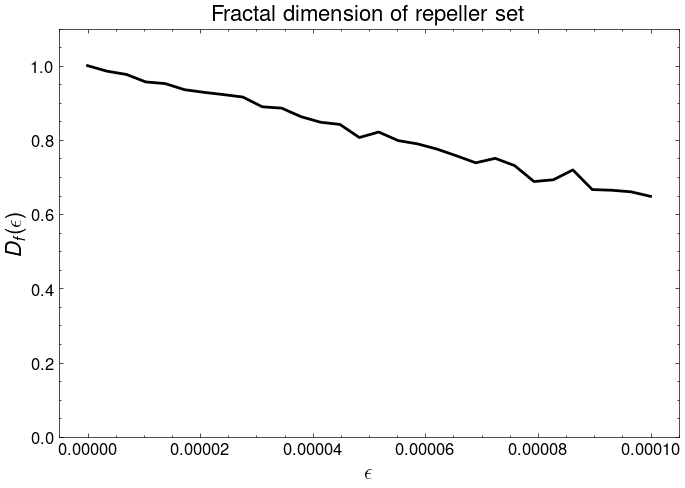


Key Results:
ε            Dimension    Escape Rate 
----------------------------------------
0.000000     1.0000       -0.0000     
0.000017     0.9351       0.0450      
0.000034     0.8854       0.0794      
0.000052     0.8210       0.1241      
0.000069     0.7381       0.1815      
0.000086     0.7190       0.1948      


In [12]:
# Plot fractal dimension only
plt.figure(figsize=(7, 5))
plt.plot(epsilon_values, dimensions, 'k', linewidth=2)
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.ylabel(r"$D_f(\epsilon)$", fontsize=16)
plt.title('Fractal dimension of repeller set', fontsize=16)
# plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('./plots/fractal_dimension_repeller.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print key results
print(f"\nKey Results:")
print(f"{'ε':<12} {'Dimension':<12} {'Escape Rate':<12}")
print("-" * 40)
for i in range(0, len(epsilon_values), 5):
    eps = epsilon_values[i]
    dim = dimensions[i]
    gamma = escape_rates[i] if escape_rates[i] < np.inf else float('inf')
    print(f"{eps:<12.6f} {dim:<12.4f} {gamma:<12.4f}")

# Problem 4

In [6]:
# Map
def log_map(x, b=0):
    """
    """
    return b + np.log(np.abs(x))

In [10]:
def fixed_point_map(x, b=0):
    """
    Fixed point map for the logistic map
    """
    return x - log_map(x, b)

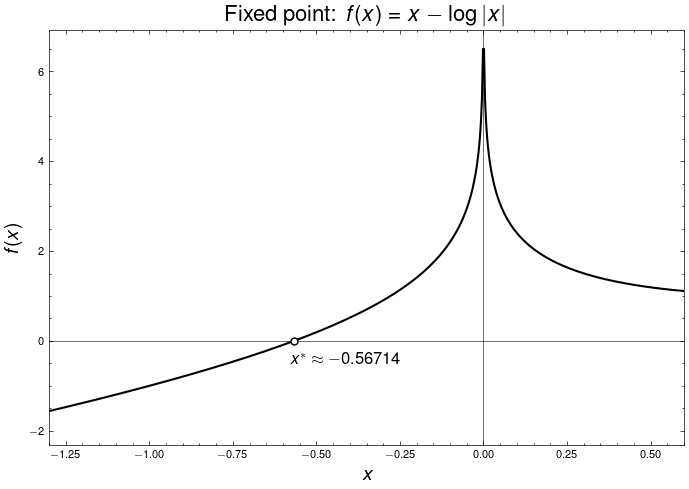

In [49]:
# Array
x_array = np.linspace(-1.5, 1.5, 1000)

# Feed
y = fixed_point_map(x_array, b=0)

plt.figure(figsize=(7, 5))
plt.title("Fixed point: " + r"$f(x) = x - \log|x|$", fontsize=16)
plt.plot(x_array, y, lw=1.5, c='k')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$f(x)$', fontsize=14)
plt.axhline(0, color='black', lw=0.4)
plt.axvline(0, color='black', lw=0.4)

# Point of intersection
plt.plot(-0.56714, 0, 'wo', markersize=5, markeredgecolor='black', markeredgewidth=1.0)
plt.text(-0.58, -0.5, r"$x^* \approx -0.56714$", fontsize=12, color='black', weight='bold')

# Make ticks smaller
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlim(-1.3, 0.6)
#plt.ylim(-1.0, 1.0)
plt.tight_layout()
# plt.savefig('./plots/fixed_point.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
# Set a
b = 0

# Number of iterations
n_iterations = 100

# Initialize array
x_values = np.zeros(n_iterations)

# Set initial condition
x_values[0] = 0.1

# Iterate
for i in range(1, n_iterations):
    x_values[i] = log_map(x_values[i-1], b)

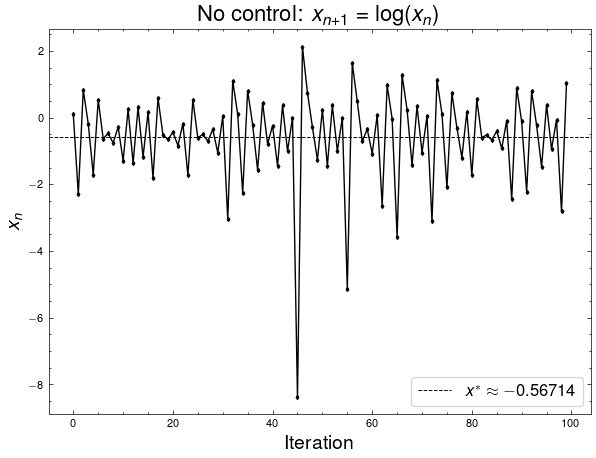

In [ ]:
plt.figure(figsize=(7, 5))

plt.title("No control: "+ r'$x_{n+1} = \log(x_n)$', fontsize=16)

plt.plot(range(n_iterations), x_values, markersize=2, c='k', alpha=1.0, lw=1.0, marker ='d')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel(r'$x_n$', fontsize=14)

plt.axhline(-0.56714, color='black', lw=0.7, label =r"$x^* \approx -0.56714$", ls ='--')
# plt.axvline(0, color='black', lw=0.4)
# Make ticks smaller and only show integer ticks
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(fontsize=12, frameon=True, loc='lower right')

#plt.xlim(900,1001)
#plt.ylim(-6, 3)
# plt.savefig('./plots/no_control_log.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [124]:
# Same map with control
def log_map_control(x, b, eps, control_force=0.1, unstable_fixed_point=1.0):
    """
    Log map with control
    """
    # Compute the next value
    x_new = b + np.log(np.abs(x))
    
    # Apply control if close to unstable fixed point
    if abs(x_new - unstable_fixed_point) < eps:
        x_new += control_force * (unstable_fixed_point - x_new)
    
    return x_new

In [125]:
# Set a
b = 0

# Number of iterations
n_iterations = 100

# Initialize array
x_vals = np.zeros(n_iterations)

# Set initial condition
x_vals[0] = -0.79

# Iterate
for i in range(1, n_iterations):
    x_vals[i] = log_map_control(x_vals[i-1], b, eps=0.1, control_force=0.50, unstable_fixed_point=-0.56714)

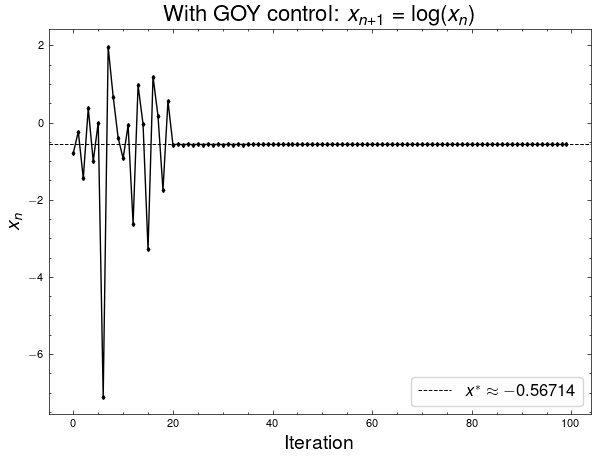

In [128]:
plt.figure(figsize=(7, 5))

plt.title("With GOY control: " + r'$x_{n+1} = \log(x_n)$', fontsize=16)

plt.plot(range(n_iterations), x_vals, markersize=2, c='k', alpha=1.0, lw=1.0, marker ='d')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel(r'$x_n$', fontsize=14)

plt.axhline(-0.56714, color='black', lw=0.7, label =r"$x^* \approx -0.56714$", ls ='--')
# plt.axvline(0, color='black', lw=0.4)
# Make ticks smaller and only show integer ticks
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(fontsize=12, frameon=True, loc='lower right')

#plt.xlim(900,1001)
#plt.ylim(-6, 3)
plt.savefig("./plots/goy_control.pdf",  dpi=300, bbox_inches='tight')
plt.show()